# New York Subway Network

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## 1. Import of Data

In [2]:
datafile='data/DOITT_SUBWAY_STATION_01_13SEPT2010.csv'
df = pd.read_csv(datafile)
df.set_index('OBJECTID',inplace=True)
df = df[['the_geom','NAME','LINE']]
df.head()

,the_geom,NAME,LINE
OBJECTID,,,
1,POINT (-73.99106999861966 40.73005400028978),Astor Pl,4-6-6 Express
2,POINT (-74.00019299927328 40.71880300107709),Canal St,4-6-6 Express
3,POINT (-73.98384899986625 40.76172799961419),50th St,1-2
4,POINT (-73.97499915116808 40.68086213682956),Bergen St,2-3-4
5,POINT (-73.89488591154061 40.66471445143568),Pennsylvania Ave,3-4


In [3]:
def get_lat_long(point):
    point = point.split()
    long = float(point[1][1:])
    lat = float(point[2][:-1])
    return(lat, long)

In [4]:
df['the_geom'] = df['the_geom'].apply(lambda x: get_lat_long(x))

## 2. Merge all the Stations with the same Name and the same location

In [8]:
def add_together(df):
    from geopy.distance import great_circle
    x = df[df.duplicated('NAME', keep=False)].sort_values('NAME')
    for i in set(x['NAME']):
        coord = list()
        objid = dict()
        for index, row in df[df['NAME'] == i].iterrows():
            coord.append((row['the_geom'], index))
        for m in range(len(coord)):
            objid[coord[m][1]]=list()
            for k in range(m+1, len(coord)):
                dist = great_circle(coord[m][0], coord[k][0]).meters
                if dist < 200:
                    objid[coord[m][1]].append(coord[k][1])
        #objid = list(set(objid))
        #print(objid)
        new=list()
        for k,v in objid.items():
            if v:
                if len(v)==1:
                    new.extend([v[0],k]) 
                else :
                    new.extend(v)
                    new.append(k)
                    
        
        new=list(set(new))
        #print(new)
        lines = '-'.join(list(df.loc[new]['LINE']))
        df.loc[new, 'LINE'] = lines
        df=df.drop(new[1:])
    return df

In [9]:
df=add_together(df)

## 3. Get the order in which the stations are deserved by the lines from http://web.mta.info/nyct/service

In [10]:

def get_stations(string):
    import requests
    from bs4 import BeautifulSoup
    stations = list()
    url = 'http://web.mta.info/nyct/service/{}.htm'.format(string)
    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    begin = results_page.find(
        'div', id='contentbox').find_all('tr', height='25')
    #print(string)
    for i in begin:
        try:
            station = i.find('span').get_text()
            stations.append(' '.join(station.replace(
                '\r', '').replace('Parkway', 'Pkwy').replace('-', ' - ').replace('Saint ', 'St ').replace('Fort ', 'Ft ').replace('West ', 'W ').replace('East ', 'E ').replace('Eern', 'Eastern').replace('Avenue', 'Ave').replace('Street', 'St').strip('/').split()))
        except:
            try:
                station = i.find('strong').get_text()
                stations.append(' '.join(station.replace('\r', '').replace(
                    '-', ' - ').replace('Parkway', 'Pkwy').replace('Saint ', 'St ').replace('Fort ', 'Ft ').replace('West ', 'W ').replace('East ', 'E ').replace('Eern', 'Eastern').replace('Avenue', 'Ave').replace('Street','St').strip('/').split()))
            except:
                continue
    return stations

In [11]:
addresses = ['oneline', 'twoline', 'threelin', 'fourline', 'fiveline', 'sixline', '6d', 'sevenlin', '7d',
             'aline', 'bline', 'cline', 'dline', 'eline', 'fline', 'gline', 'jline', 'lline', 'mline', 'nline', 'qline', 'rline', 'sline', 'wline', 'zline']

In [12]:
subways=dict()
k=0
for i in addresses:
    k+=1
    subways[k]=get_stations(i)
    

In [13]:
# Corrections
del subways[13][-9]
subways[13]
subways[21][11]='Beverly Rd'
subways[10][5]='168 St'
subways[12][0]= '168 St'
subways[23][1]='Grand Central - 42 St'

In [14]:
# Get the id for every name of the stations
def get_id_stop(stop_list, df, line):
    obj_list = list()
    for i in stop_list:
        if i:
            #print(i)
            if i=='Broadway - Lafayette St / Bleecker St' and line in ['4','6']:
                i='Bleecker St'
            m = i.split()[0]
            if len(i.split()) > 1:
                k = i.split()[1]
            try:
                obj_id = df[(df['NAME'].str.find(i) != -1) &
                            (df['LINE'].str.find(line) != -1)]
                if obj_id.empty:
                    obj_id = df[(df['NAME'].str.find(m) != -1) & (df['NAME'].str.find(
                        m + ' ' + k[0]) != -1) & (df['LINE'].str.find(line) != -1)]
                if obj_id.empty:
                    obj_id = df[(df['NAME'].str.find(m) != -1) &
                                (df['LINE'].str.find(line) != -1)]
                if len(obj_id)>1:
                    obj_id = df[(df['NAME'].str.find(m) != -1) & (df['NAME'].str.find(k[:2]) != -1) & (df['LINE'].str.find(line) != -1)]
                obj_list.append(obj_id.sort_values('NAME').index[-1])
            except:
                obj_list.append(i)
    return obj_list

In [16]:
df.loc[142,'NAME']='5th Ave'
df.loc[143,'NAME']='Lexington Ave'
df.loc[225,'LINE']='J-Z'

In [17]:
lines=['1','2','3','4','5','6','6 Express','7','7 Express','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

In [18]:
subway_ordered_stops=list()
j=0
for i in lines:
    #print(i)
    j+=1
    #print(j)
    subway_ordered_stops.append(get_id_stop(subways[j],df,i))

In [44]:
#Corrections
subway_ordered_stops[6].insert(5,28)
subway_ordered_stops[24].insert(4,78)
subway_ordered_stops[20].insert(4,78)
subway_ordered_stops[12].insert(0,275)
subway_ordered_stops[9][11]=398
subway_ordered_stops[9].insert(-14,124)
subway_ordered_stops[18].insert(1000,424)
subway_ordered_stops[18].insert(-1,423)
subway_ordered_stops[18].insert(-2,449)
subway_ordered_stops[18].insert(-3,234)
subway_ordered_stops[18].insert(-4,233)
subway_ordered_stops[18].insert(-5,303)
subway_ordered_stops[18].insert(-6,302)
subway_ordered_stops[18].insert(-7,373)
subway_ordered_stops[18].insert(-8,372)
subway_ordered_stops[18].insert(-9,76)
subway_ordered_stops[18].insert(-10,140)
subway_ordered_stops[5][13]=258
subway_ordered_stops[0].insert(3,266)
subway_ordered_stops[12][-11]=311
subway_ordered_stops[21][-1]=317
subway_ordered_stops[21][13]=356
subway_ordered_stops[19][7]=356
subway_ordered_stops[23][7]=356
subway_ordered_stops[21][-5]=387
subway_ordered_stops[19][-11]=387
subway_ordered_stops[20].insert(1,351)
subway_ordered_stops[20].insert(1,643)
subway_ordered_stops[20].insert(1,642)
subway_ordered_stops[20].insert(1,641)
del(subway_ordered_stops[0][-3])

In [45]:
subway_ordered_stops[0]

[271,
 6,
 267,
 266,
 266,
 268,
 269,
 286,
 179,
 178,
 177,
 157,
 156,
 172,
 287,
 167,
 166,
 159,
 158,
 86,
 193,
 162,
 88,
 353,
 3,
 80,
 358,
 199,
 96,
 203,
 439,
 195,
 97,
 90,
 464,
 361,
 425,
 418]

In [46]:

j=0
for i in subway_ordered_stops:
    print('line',lines[j],':',i)
    j+=1
    

line 1 : [271, 6, 267, 266, 266, 268, 269, 286, 179, 178, 177, 157, 156, 172, 287, 167, 166, 159, 158, 86, 193, 162, 88, 353, 3, 80, 358, 199, 96, 203, 439, 195, 97, 90, 464, 361, 425, 418]
line 2 : [280, 41, 87, 248, 273, 40, 276, 257, 39, 44, 285, 272, 256, 18, 43, 19, 254, 253, 41, 290, 169, 168, 170, 160, 158, 86, 193, 162, 88, 353, 3, 80, 358, 199, 41, 285, 290, 195, 97, 90, 464, 361, 403, 360, 430, 446, 123, 405, 128, 121, 4, 115, 129, 42, 455, 134, 45, 131, 130, 132, 133]
line 3 : [261, 173, 169, 168, 170, 160, 158, 162, 80, 358, 261, 361, 403, 360, 430, 446, 123, 405, 128, 121, 4, 115, 129, 42, 445, 136, 135, 222, 221, 218, 217, 5, 46, 213]
line 4 : [456, 274, 260, 259, 408, 407, 175, 174, 262, 264, 291, 48, 289, 141, 468, 462, 450, 458, 33, 451, 34, 102, 49, 85, 204, 32, 200, 92, 384, 1, 457, 467, 417, 29, 360, 420, 419, 123, 128, 121, 4, 115, 129, 42, 445, 136, 135, 222, 221, 218, 217, 5, 46, 213]
line 5 : [278, 277, 284, 126, 125, 41, 87, 248, 273, 284, 276, 257, 126, 44, 28

In [47]:
df.loc[356]

the_geom    (40.764810999755284, -73.97334700047045)
NAME                               5th Ave - 59th St
LINE                                           N-R-W
Name: 356, dtype: object

## Network Analysis on the New York Subway Network

In [48]:
import networkx as nx
Graph = nx.Graph()
edges=list()
line_edge=list()
for e in subway_ordered_stops:
    inter_edge=list()
    for stop in range(len(e)-1):
        inter_edge.append((e[stop],e[stop+1]))
    edges.extend(inter_edge)
    line_edge.append(inter_edge)

In [49]:
color = {0: 'red', 1: 'red', 2: 'red', 3: 'green', 4: 'green', 5: 'green', 6: 'green', 7: 'purple',
         8: 'purple', 9: 'blue', 10: 'orange', 11: 'blue', 12: 'orange',13:'blue', 14: 'orange', 15: 'green', 16: 'brown', 17: 'grey', 18: 'orange', 19: 'yellow', 20: 'yellow', 21: 'yellow', 22: 'grey', 23: 'yellow', 24: 'brown'}

In [50]:
Graph.add_nodes_from(list(df.index))
Graph.add_edges_from(edges)

In [51]:
#Get the position for every node
def coord_pos(df):
    pos=dict()
    for i in df.index:
        coord=list(df.loc[i]['the_geom'])
        coord=coord[::-1]
        pos[i]=tuple(coord)
    return pos
    

In [52]:
Graph.nodes()[-1]

643

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


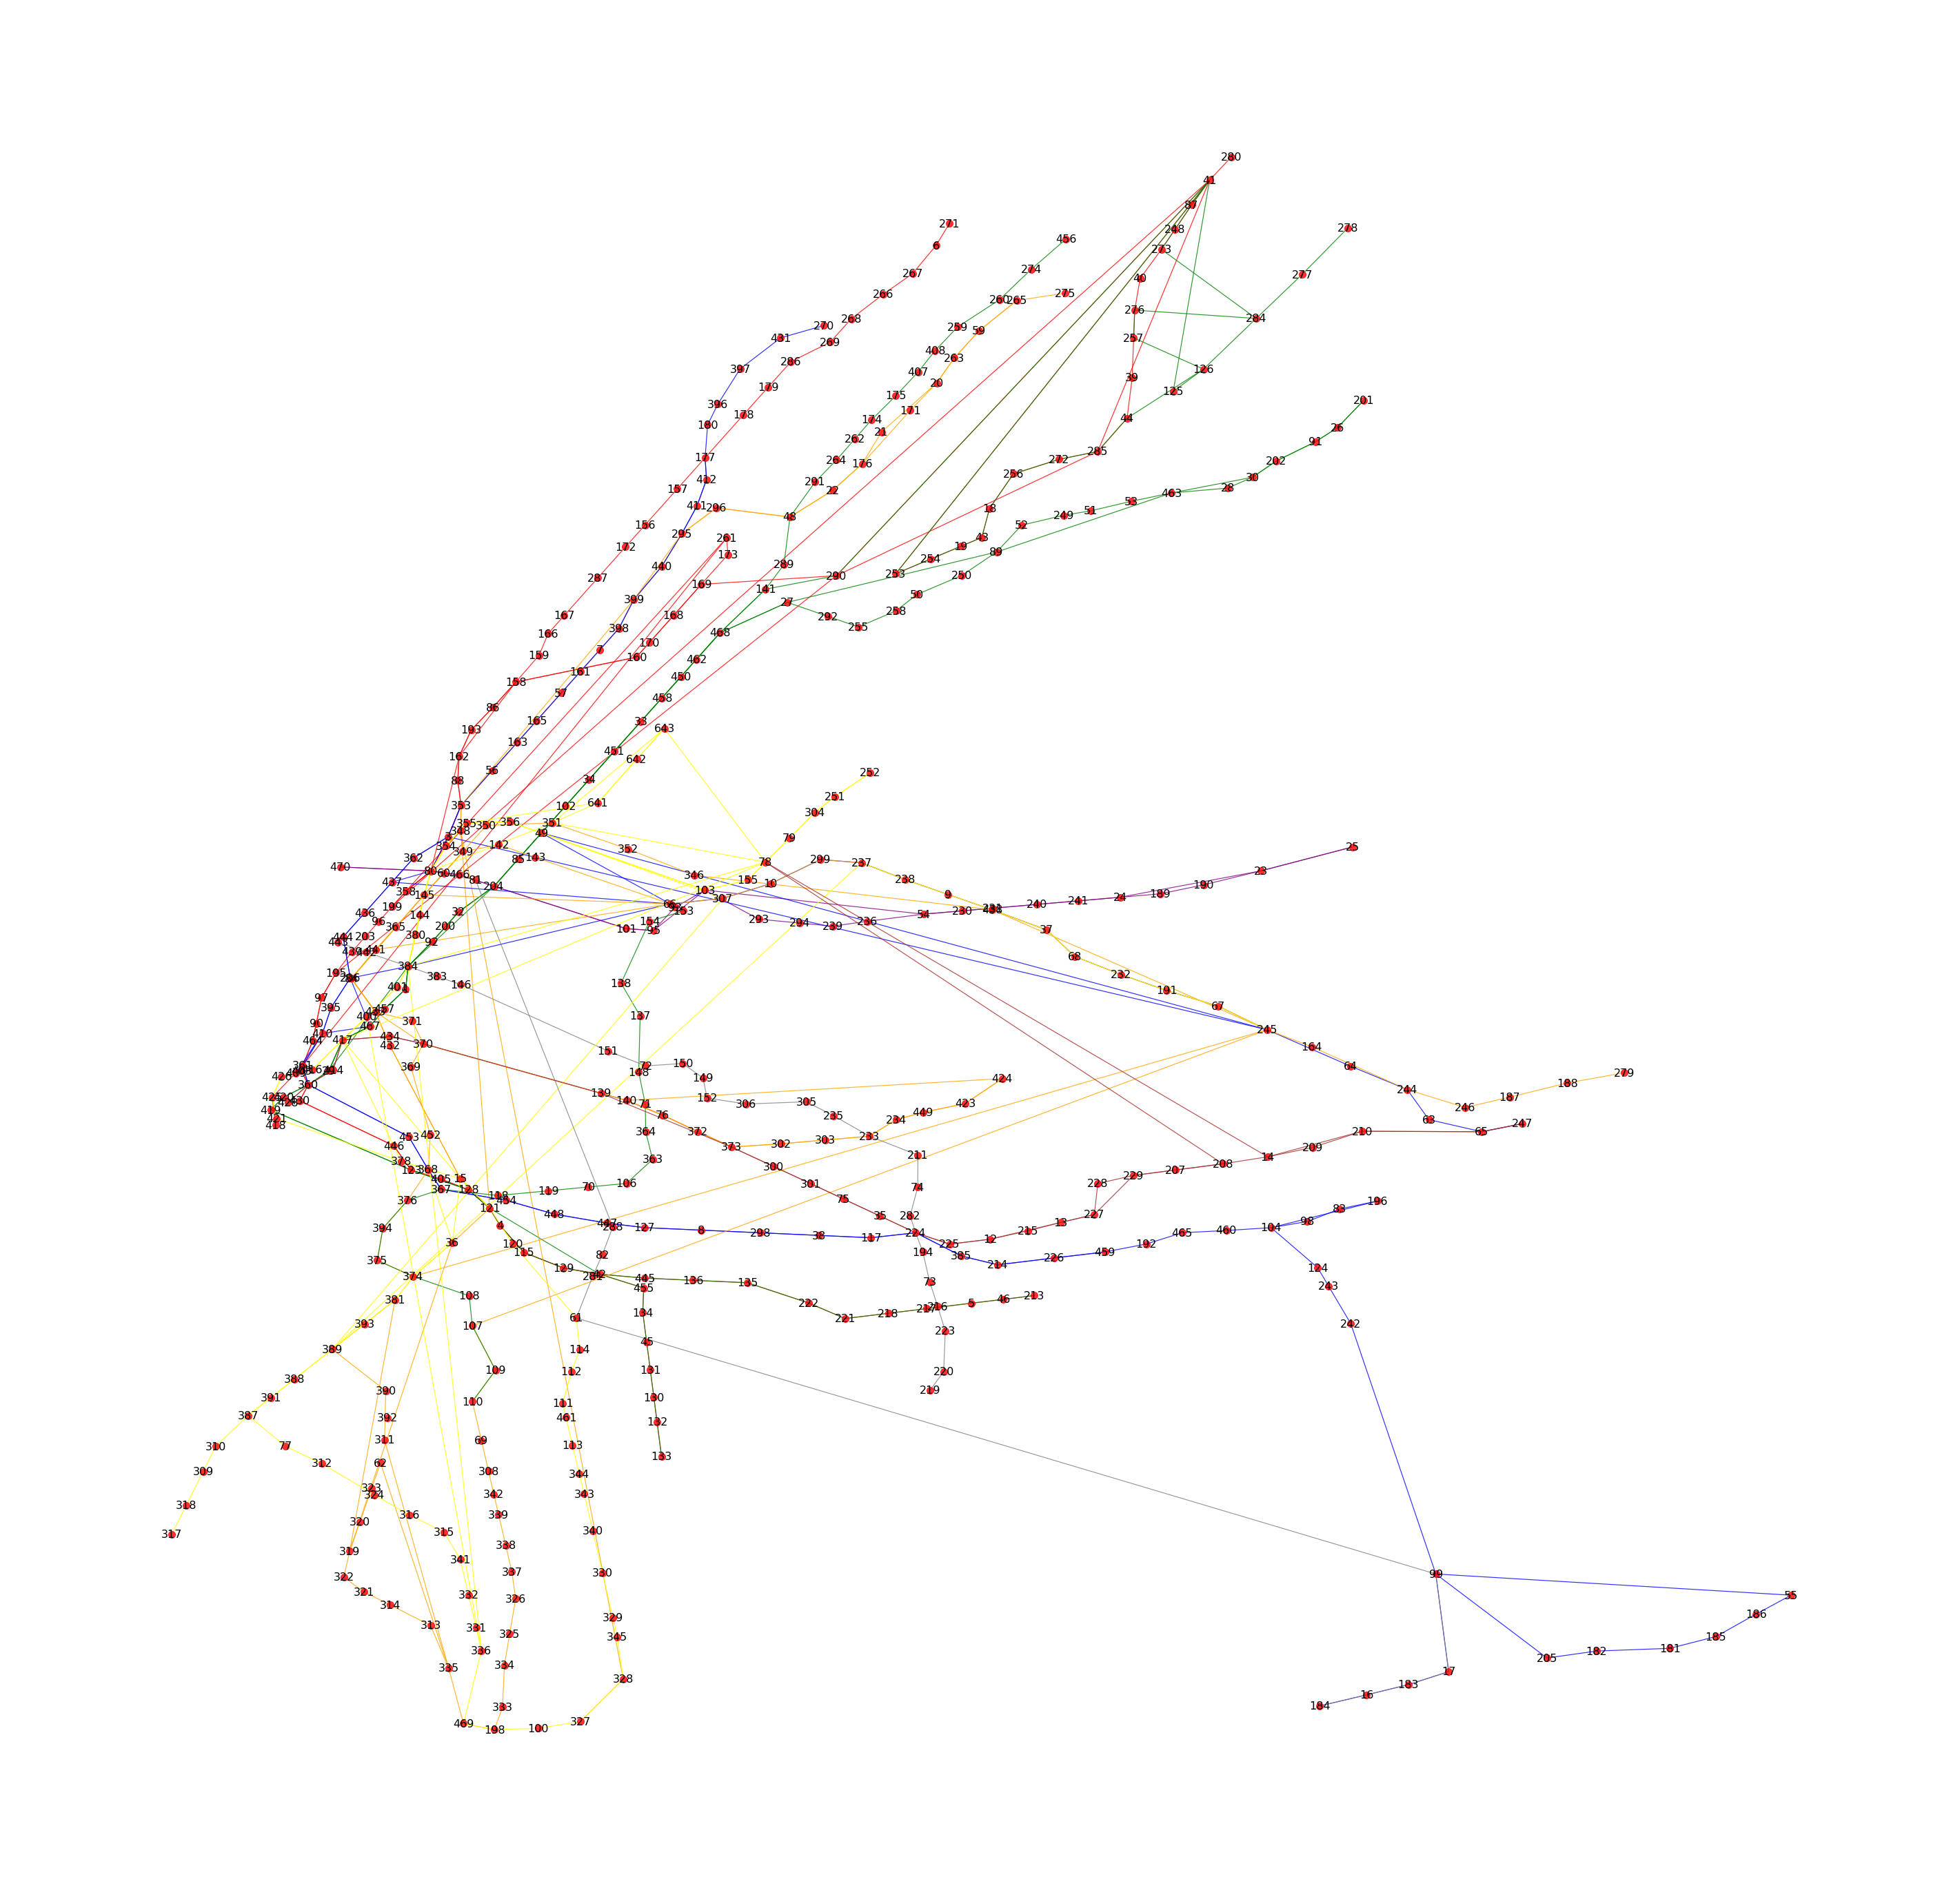

In [53]:
%matplotlib inline
pos = coord_pos(df)  # positions for all nodes
fig = plt.figure(1, figsize=((50, 50)))
# nodes
nx.draw_networkx_nodes(Graph, pos,
                       node_color='red',
                       node_size=100,
                       alpha=0.8)

# edges
# nx.draw_networkx_edges(sub_graph,pos,width=1.0,alpha=0.5)
for i in range(len(line_edge)):
    nx.draw_networkx_edges(Graph, pos,
                           edgelist=line_edge[i],
                           width=1.2, alpha=0.8, edge_color=color[i])


node_name = {}
for node in Graph.nodes():
    node_name[node] = str(node)


nx.draw_networkx_labels(Graph, pos, node_name, font_size=16)

plt.axis('off')
fig.show()

In [288]:
from geojsonio import display

with open('data/Subway_Stations.geojson') as f:
    contents = f.read()
    display(contents)

In [289]:
print(len(list(nx.connected_components(Graph))))

1


In [290]:
for comp in nx.connected_components(Graph):
    print(comp)

{1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 

## Closeness Centrality

In [293]:
from networkx.algorithms.centrality import closeness_centrality, communicability
from collections import OrderedDict
cc = OrderedDict(sorted(
                    closeness_centrality(Graph).items(),
                    key = lambda x: x[1],
                    reverse = True))

In [294]:
for i in list(cc)[:15]:
    print(df.loc[i]['NAME'],'for Line(s) :',df.loc[i]['LINE'])

Lexington Ave - 59th St for Line(s) : 4-5-6-6 Express-N-R-W
50th St for Line(s) : 1-2-A-C-E
Herald Sq - 34th St for Line(s) : N-Q-R-W-B-D-F-M
Forest Hills - 71st Av for Line(s) : E-F-M-R
Times Sq - 42nd St for Line(s) : N-Q-R-W-S-7-7 Express-1-2-3
Union Sq - 14th St for Line(s) : L-4-5-6-6 Express-N-Q-R-W
Court Sq - 23rd St for Line(s) : E-M
Union St for Line(s) : D-N-R
Atlantic Av - Barclay's Center for Line(s) : B-Q-D-N-Q-R-2-3-4-5
4th Av - 9th St for Line(s) : F-G-D-N-R
59th St - Columbus Circle for Line(s) : A-B-C-D-1-2
7th Ave for Line(s) : B-D-E
Canal St for Line(s) : R-W-4-6-6 Express-N-Q-J-Z
DeKalb Ave for Line(s) : B-D-N-Q-R
Grand Central - 42nd St for Line(s) : 7-7 Express-4-5-6-6 Express


## Betweeness Centrality

In [295]:
bc = OrderedDict(sorted(
                    nx.betweenness_centrality(Graph).items(),
                    key = lambda x: x[1],
                    reverse = True))

In [296]:
print('Bottlenecks: ')
for i in list(bc)[:15]:
    print(df.loc[i]['NAME'],'for Line(s) :',df.loc[i]['LINE'])

Bottlenecks: 
Lexington Ave - 59th St for Line(s) : 4-5-6-6 Express-N-R-W
Atlantic Av - Barclay's Center for Line(s) : B-Q-D-N-Q-R-2-3-4-5
Forest Hills - 71st Av for Line(s) : E-F-M-R
Times Sq - 42nd St for Line(s) : N-Q-R-W-S-7-7 Express-1-2-3
59th St - Columbus Circle for Line(s) : A-B-C-D-1-2
Union Sq - 14th St for Line(s) : L-4-5-6-6 Express-N-Q-R-W
Union St for Line(s) : D-N-R
7th Ave for Line(s) : B-D-E
125th St for Line(s) : 4-5-6-6 Express
Delancey St - Essex St for Line(s) : F-J-M-Z
86th St for Line(s) : 4-5-6-6 Express
125th St for Line(s) : A-B-C-D
Marcy Ave for Line(s) : J-M-Z
145th St for Line(s) : A-B-C-D
Myrtle Ave for Line(s) : J-M-Z


In [297]:
print('Average Clustering: {}'.format(nx.average_clustering(Graph)))

Average Clustering: 0.04239056569373311


In [299]:
#cc=nx.communicability(Graph)

In [313]:
print(nx.shortest_path(Graph,1,49))
df.loc[49]

[1, 384, 204, 49]


the_geom    (40.762526000304575, -73.9679670004732)
NAME                        Lexington Ave - 59th St
LINE                          4-5-6-6 Express-N-R-W
Name: 49, dtype: object

In [306]:
print('Eccentricity: {}'.format(nx.eccentricity(Graph)))
print('Diameter: {}'.format(nx.diameter(Graph)))
print('Periphery: {} and {}'.format(df.loc[nx.periphery(Graph)[0]]['NAME'],df.loc[nx.periphery(Graph)[1]]['NAME']))


Eccentricity: {1: 19, 3: 17, 4: 18, 5: 26, 6: 30, 7: 20, 8: 25, 9: 19, 10: 19, 12: 24, 13: 23, 14: 20, 15: 18, 16: 23, 17: 21, 18: 24, 19: 23, 20: 25, 21: 24, 22: 22, 23: 21, 24: 20, 25: 22, 26: 26, 27: 20, 28: 23, 29: 19, 30: 23, 32: 19, 33: 19, 34: 19, 35: 26, 36: 18, 37: 19, 38: 27, 39: 23, 40: 24, 41: 20, 42: 18, 43: 24, 44: 22, 45: 21, 46: 27, 48: 21, 49: 17, 50: 23, 51: 24, 52: 22, 53: 23, 54: 19, 55: 21, 56: 18, 57: 21, 59: 27, 60: 18, 61: 19, 62: 22, 63: 20, 64: 18, 65: 21, 66: 18, 67: 18, 68: 20, 69: 21, 70: 23, 71: 27, 72: 22, 73: 27, 74: 27, 75: 25, 76: 24, 77: 23, 78: 19, 79: 20, 80: 18, 81: 19, 82: 20, 83: 26, 84: 19, 85: 18, 86: 21, 87: 21, 88: 18, 89: 21, 90: 20, 91: 25, 92: 19, 93: 19, 95: 19, 96: 20, 97: 19, 98: 25, 99: 20, 100: 19, 101: 19, 102: 18, 103: 18, 104: 24, 106: 24, 107: 18, 108: 19, 109: 19, 110: 20, 111: 22, 112: 21, 113: 24, 114: 20, 115: 19, 117: 26, 118: 21, 119: 22, 120: 18, 121: 17, 123: 19, 124: 23, 125: 21, 126: 22, 127: 24, 128: 18, 129: 19, 130: 2

In [305]:
df.loc[153]

the_geom    (40.74630503357145, -73.94381559597835)
NAME                    Long Island City - Court Sq
LINE                                              G
Name: 153, dtype: object

In [1362]:
import gmplot
gmap = gmplot.GoogleMapPlotter.from_geocode("New York")
gmap.heatmap(df1['Latitude'],df1['Longitude'])

In [1363]:
gmap.draw('MTA.html')